In [599]:
# imports

import pandas as pd
import yfinance as yf
import yahoofinancials as YahooFinancials
from datetime import date, datetime, timedelta
import plotly
import os
import matplotlib.pyplot as plt


import numpy as np
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense , Dropout , LSTM, CuDNNLSTM
from keras.preprocessing.sequence import TimeseriesGenerator

In [600]:
# Define the lookup for the stock (name, price, symbol)

import requests
import urllib.parse


api_key = 'pk_35ab12ce73ea4cf38d7641e8d3b01de7'

def lookup(symbol, api_key="pk_35ab12ce73ea4cf38d7641e8d3b01de7"):
    """Look up quote for symbol."""

    # Contact API
    try:
        response = requests.get(
            f"https://cloud.iexapis.com/stable/stock/{urllib.parse.quote_plus(symbol)}/quote?token={api_key}")
        response.raise_for_status()
    except requests.RequestException:
        return None

    # Parse response
    try:
        quote = response.json()
        return {
                "name": quote["companyName"],
                "price": float(quote["latestPrice"]),
                "symbol": quote["symbol"]
                }
    except (KeyError, TypeError, ValueError):
        return None


In [601]:
# input the stock symbol

symbol = input("Enter a stock symbol: ")

In [602]:
# get todays date

today = date.today()
print(today)

2022-04-09


In [603]:
# print the lookup for the sumbol

print(lookup(symbol))

{'name': 'Apple Inc', 'price': 170.09, 'symbol': 'AAPL'}


In [604]:
# date mathematics
# another import line because the code doesn't work without it

from datetime import datetime, timedelta

timedifference = input("Enter a time difference in months: ")
timedifference = int(timedifference)

# timedifference is the number of months
timediffdays = timedifference * 30
# timediffdays is the number of days

startdate = datetime.today() - timedelta(days=timediffdays)
print(startdate)


2002-07-23 11:09:54.149702


In [605]:
# gets data from yahoo finance from a set date to today

stock_df = yf.download(symbol, 
                      start=startdate, 
                      end=today, 
                      progress=False,
)
#stock_df.drop(columns=['High', 'Low', 'Close', 'Adj Close', 'Volume'], inplace=True)
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-07-23,0.266071,0.270179,0.257857,0.258393,0.221255,399890400
2002-07-24,0.255893,0.271786,0.254464,0.271429,0.232418,406593600
2002-07-25,0.266607,0.266964,0.250179,0.256429,0.219574,479354400
2002-07-26,0.258214,0.259464,0.246429,0.256071,0.219267,207704000
2002-07-29,0.258571,0.269643,0.256607,0.268214,0.229665,274960000


In [606]:
# turn datafram to csv
# os.remove('data.csv')
stock_df.to_csv('data.csv')

In [607]:
filename = "data.csv"
df = pd.read_csv(filename)
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4965 entries, 0 to 4964
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4965 non-null   object 
 1   Open       4965 non-null   float64
 2   High       4965 non-null   float64
 3   Low        4965 non-null   float64
 4   Close      4965 non-null   float64
 5   Adj Close  4965 non-null   float64
 6   Volume     4965 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 271.6+ KB
None


In [608]:
stock_data = stock_df
stock_data.drop(columns=['High', 'Low', 'Adj Close', 'Volume'], inplace=True)
stock_data.head()

,Open,Close
Date,,
2002-07-23,0.266071,0.258393
2002-07-24,0.255893,0.271429
2002-07-25,0.266607,0.256429
2002-07-26,0.258214,0.256071
2002-07-29,0.258571,0.268214


<AxesSubplot:>

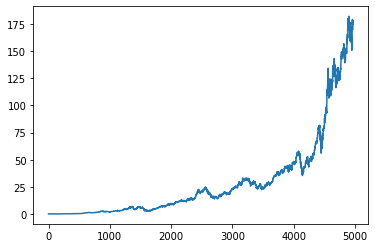

In [609]:
df1 = df.reset_index()['Close']
df1.plot()

In [610]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [611]:
training_size=int(len(df1)*0.85)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

#print(train_data)

In [612]:
import numpy
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)
time_step = 100

X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [613]:

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print(X_train)

[[[1.32619449e-04]
  [2.04334271e-04]
  [1.21814909e-04]
  ...
  [1.60126012e-04]
  [2.12190151e-04]
  [2.32819950e-04]]

 [[2.04334271e-04]
  [1.21814909e-04]
  [1.19845529e-04]
  ...
  [2.12190151e-04]
  [2.32819950e-04]
  [2.03349581e-04]]

 [[1.21814909e-04]
  [1.19845529e-04]
  [1.86647557e-04]
  ...
  [2.32819950e-04]
  [2.03349581e-04]
  [1.64053788e-04]]

 ...

 [[2.38869721e-01]
  [2.38347113e-01]
  [2.47561762e-01]
  ...
  [2.78080144e-01]
  [2.79084123e-01]
  [2.80005586e-01]]

 [[2.38347113e-01]
  [2.47561762e-01]
  [2.45650066e-01]
  ...
  [2.79084123e-01]
  [2.80005586e-01]
  [2.84062779e-01]]

 [[2.47561762e-01]
  [2.45650066e-01]
  [2.44316003e-01]
  ...
  [2.80005586e-01]
  [2.84062779e-01]
  [2.83622687e-01]]]


In [620]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [621]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [622]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

1.1163406829564178

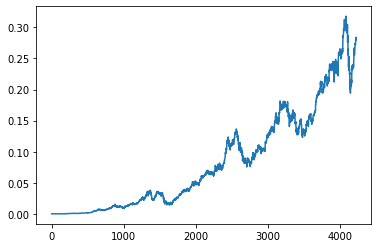

In [623]:

plt.plot(train_data)



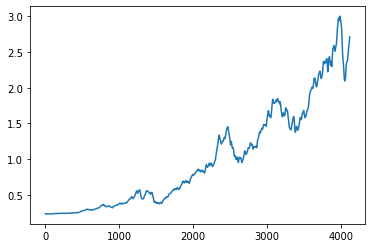

In [624]:

plt.plot(train_predict)

8.469805


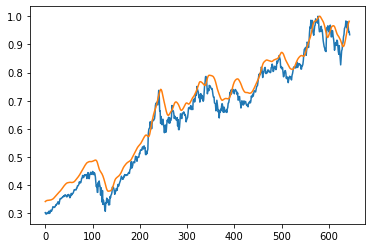

In [626]:
#test_data = scaler(test_data)
testpredictmax = numpy.amax(test_predict)
print(testpredictmax)


plt.plot(test_data[100:])
plt.plot(test_predict/testpredictmax)